# Soccer Mobile
<!-- Introduction of the project -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
plt.rcParams['figure.figsize'] = [20, 10]

## Geometry

In [2]:
from geo import *

## Vision


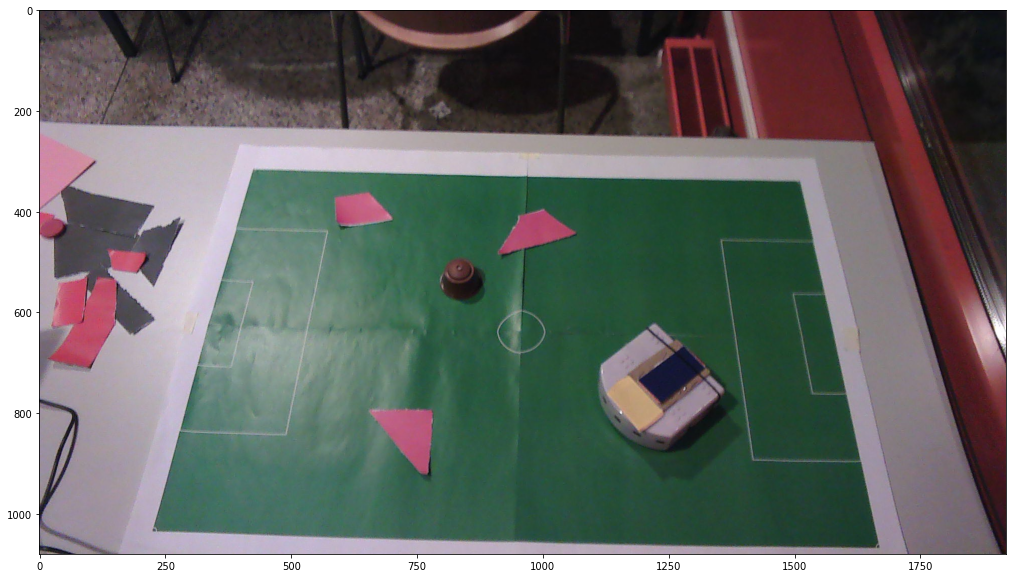

In [9]:
from vision import *
vision_processor = VisionProcessor()
img = cv2.imread("img/example.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

### Image Processing

#### Color Filtering

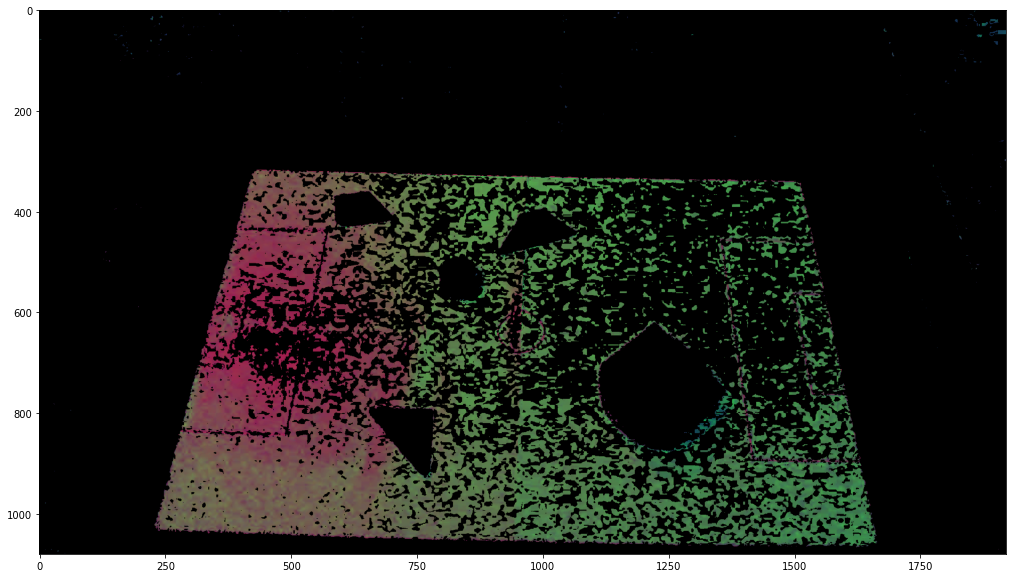

In [12]:
color = 'green'
green_mask = VisionProcessor.color_filter(img, color=color)
plt.imshow(cv2.cvtColor(green_mask, cv2.COLOR_RGB2BGR))

#### Corner Detection

##### 1. Using Image Processing

In [ ]:
# 1. find the biggest green part

gray = cv2.cvtColor(green_mask, cv2.COLOR_BGR2GRAY)
(T, thresh) = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
# morphology operation against noise
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((10, 10)))
# extract contours
_,contours,hierarchy = cv2.findContours(closing,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Taking the one with the largest area # serve as the opening operation to some extent
c = max(contours, key = cv2.contourArea)
# use a convexHull against noise
hull = cv2.convexHull(c)
hull_img = np.zeros_like(img)     
length = len(hull)
for i in range(len(hull)):
    cv2.line(hull_img, tuple(hull[i][0]), tuple(hull[(i+1)%length][0]), (255,0,0), 2)
hull_img = cv2.cvtColor(hull_img, cv2.COLOR_RGB2GRAY)
plt.imshow(hull_img)    
_,convexcontour,_ = cv2.findContours(hull_img,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ch = img.copy()
cv2.drawContours(ch,convexcontour,-1,(255,0,0),1)
#plt.imshow(cv2.cvtColor(ch, cv2.COLOR_RGB2BGR))      

corner 1680 1103
corner 214 1027
corner 1670 1061
corner 204 1059


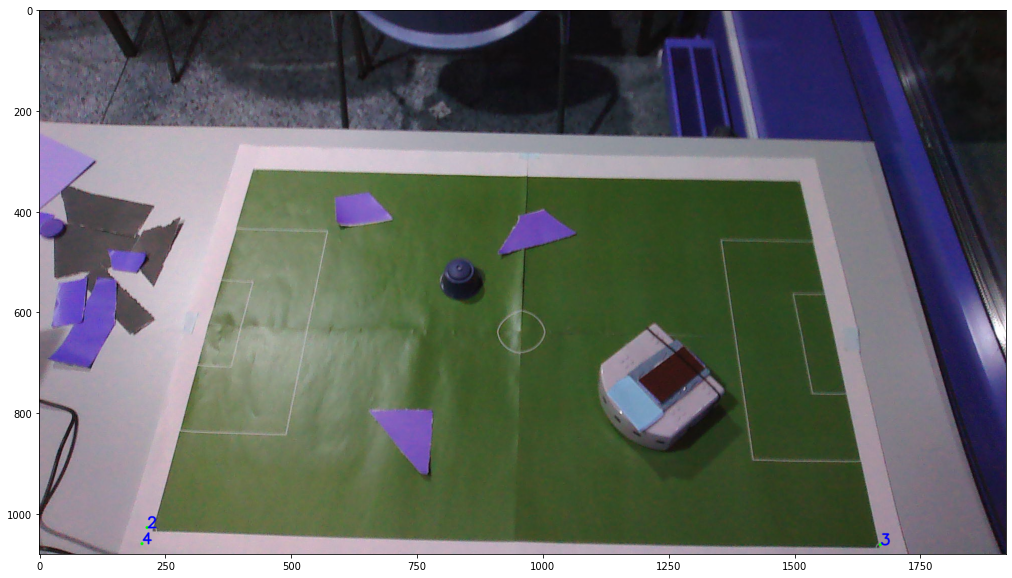

In [35]:
# 2. get 4 corners
lines = VisionProcessor.divide4(np.array(hull))
ll = lines[np.argmax([abs(l[-1]) for l in lines])]
lines.remove(ll)
rl = lines[np.argmax([abs(l[-1]) for l in lines])]
lines.remove(rl)
ul = lines[0]
dl = lines[1]
corners = []
i = 1
ch = img.copy()
for h in [ul, dl]:
    for v in [ll, rl]:
        x, y = VisionProcessor.intersection(h[0], h[1], -h[2], v[0], v[1], -v[2])
        corners.append([x, y])
        print("corner",x, y)
        cv2.circle(ch, (x, y), 3, (0, 255, 0), -1)
        cv2.putText(ch,str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        i += 1
        
corners = np.array(corners)

plt.imshow(ch)


##### 2. Using aruco

#### Perspective Projection

#### Box Detection

#### Ball Detection

### Detect Objects

#### The Field

#### The obstacles

#### The ball

#### Thymio

## Global Navigation
This module aims to plan a path from the start to the goal.
The result will be represented in form of a list of Waypoints.

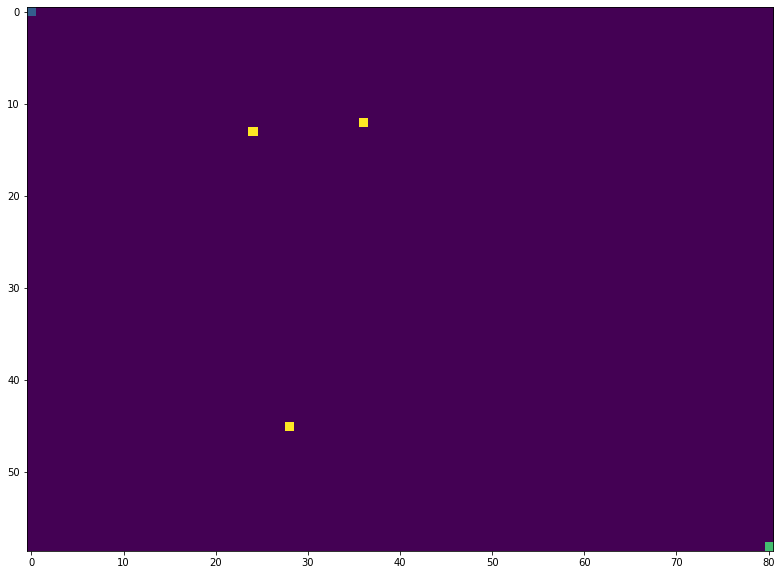

In [3]:
###
h, w = 59, 81
pStart = Pos(0,0)
pBall = Pos(h-1, w-1)
rmap = GridMap(h, w, 0.01)
rmap.set_start(pStart)
obslist = [Pos(random.randint(11,h-11),random.randint(11,w-11)) for _ in range(3)]
rmap.set_obs(obslist)

Goal_state = State(Pos(h-1,w-1), 1.57)
###

obsmap = [[int(val) for val in li] for li in rmap.obs_map]
obsmap[pStart.x][pStart.y] = 0.3
obsmap[pBall.x][pBall.y] = 0.7
plt.imshow(obsmap)

### Pre-Processing
#### Enlarge the obstacles
After getting the environment map, we need to enlarge the obstacles to make sure every point is safe for thymio.

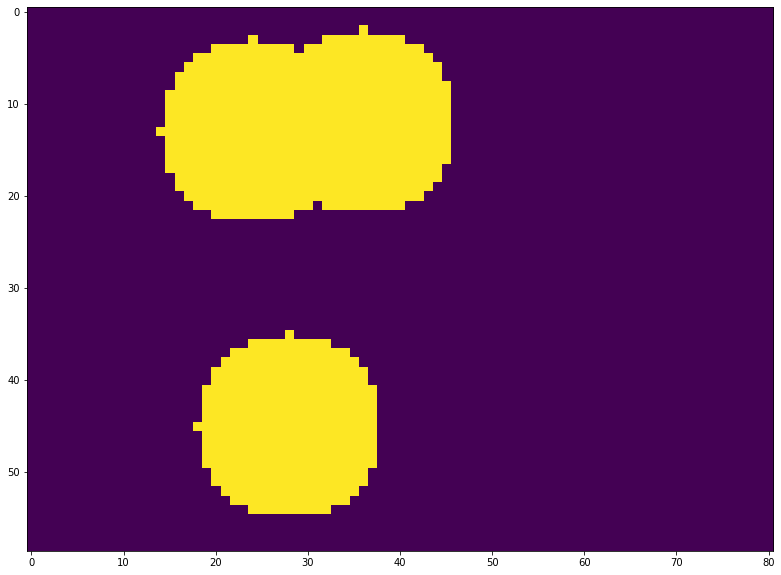

In [4]:
from global_navigation import *
planner =  PathPlanner(rmap, path_simplification=False)
plt.imshow(planner.obs) # has auto enlarged the obs when load the map

#### Caculate the actual position
The goal position represent where that the head of thmio will reach; We need to calculate the actual center position of thymio for the goal.

Goal State: (57, 80, 0.0)


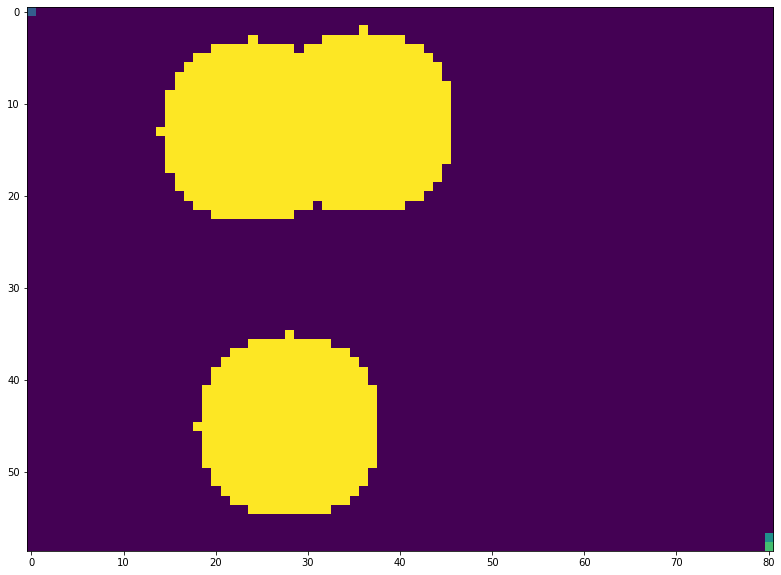

In [5]:
pGoal1 = planner.approach(pBall)
planner.set_goal(pGoal1)
print("Goal State:",pGoal1)
import copy
obs = copy.deepcopy(planner.obs)
obs[pStart.x][pStart.y] = 0.3
obs[pBall.x][pBall.y] = 0.7
obs[pGoal1.pos.x][pGoal1.pos.y] = 0.5
plt.imshow(obs)

### Path Planning
We implemented two ways of path planning, namely, A* and RRT.
A* is an optimal path planning algorithm.
RRT is usually applied for high-dimension path planning. For our project, if we get a quite large grid map, the computational cost will be high, and RRT can boost up the speed. We should note that, it's not a optimal algorithms.

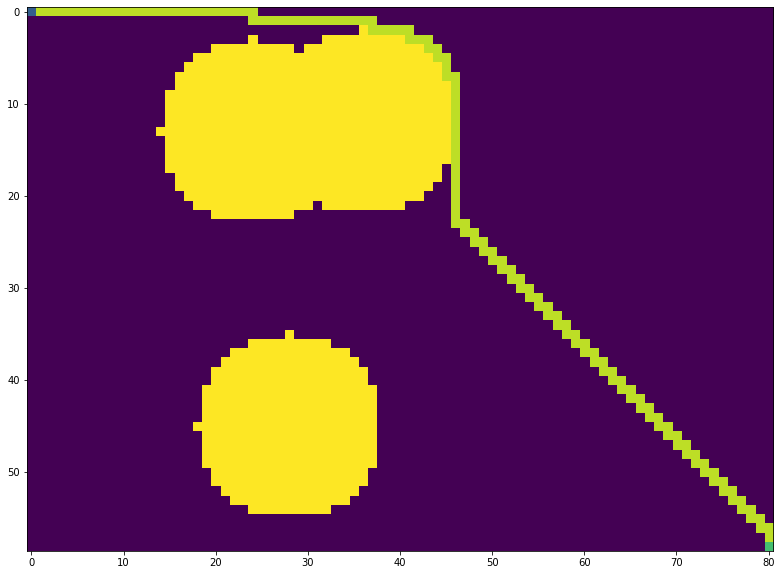

In [6]:
# the result of A*
# points in the same direction have been deleted
planner.method = "A*"
apath = planner.plan()
nobs = copy.deepcopy(obs)
for p in apath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

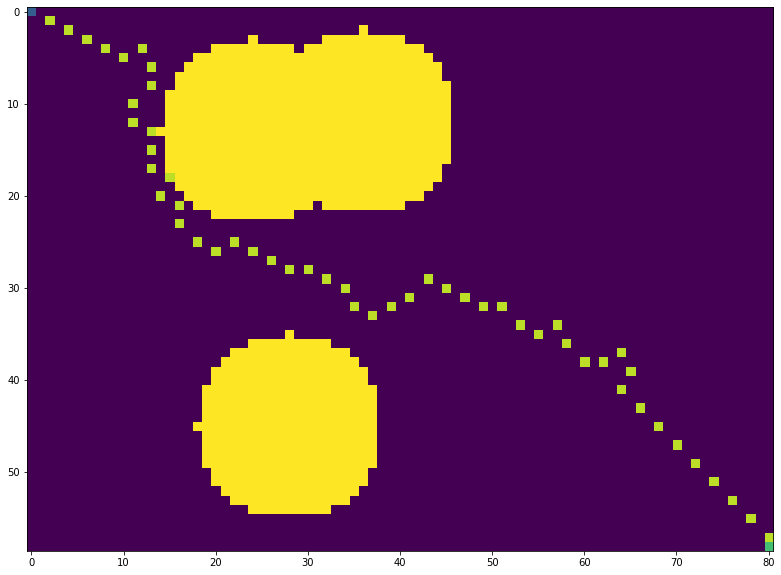

In [7]:
# the result of RRT
planner.method = "RRT"
rrtpath = planner.plan()
nobs = copy.deepcopy(obs)
for p in rrtpath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

### Post-Processing
#### Collect waypoints in same direction
The waypoints in same direction just have the same effect for path tracking, so we try to elimate some redandent points.

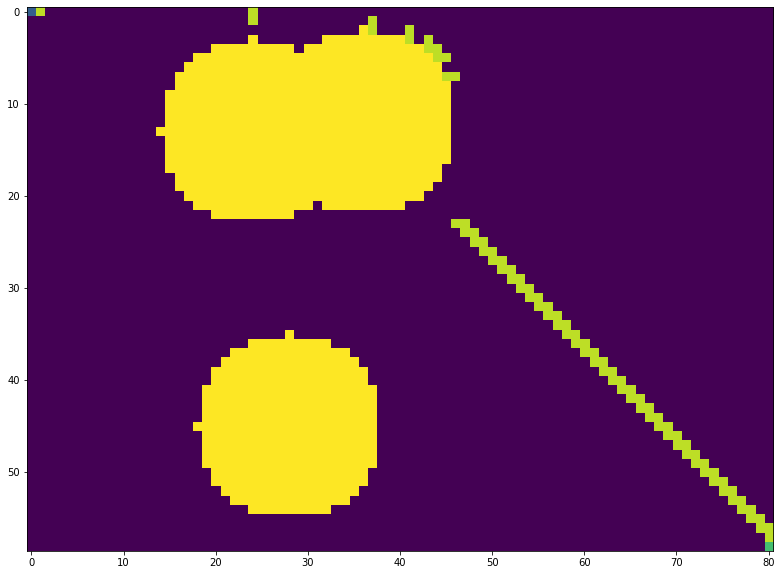

In [8]:
apath = planner.collect_wps(apath)
nobs = copy.deepcopy(obs)
for p in apath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

#### Shrink the waypoints
Try to connect the grandparent to grandchild directly.

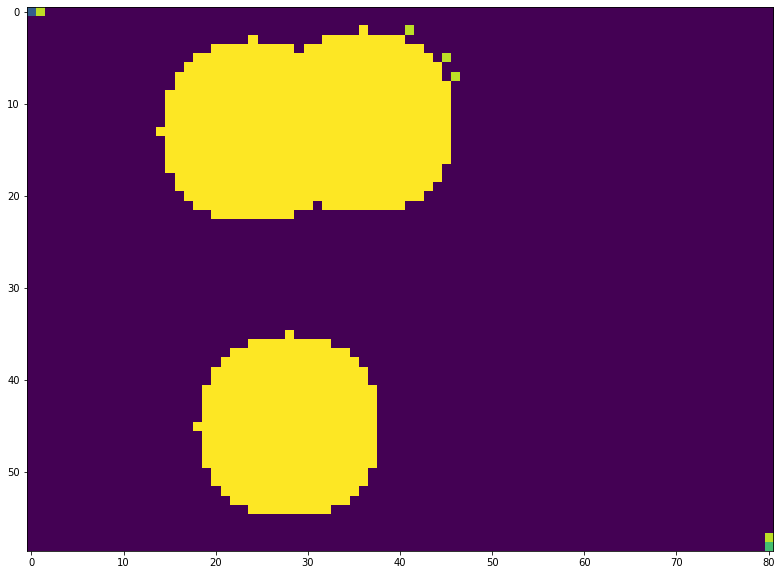

In [9]:
apath = planner.path_simplification(apath)
nobs = copy.deepcopy(obs)
for p in apath:
    nobs[p.x][p.y] = 0.9
plt.imshow(nobs)

## Local Navigation


## Filtering
tell where Thymio is.

In [12]:
import filtering
# Motor Calibration

In [ ]:
import time

In [ ]:

pre_state = np.array([1, 1, 0]).reshape(-1, 1) # initial state
pre_cov = np.ones([3, 3]) * 0.03 # initial covariance
G_filter = filtering.KF(pre_state, pre_cov, qx=0.1, qy=0.1, qtheta=0.3, rl=0.1, rr=0.1, b=0.093)
G_filter.timer = time.time()

## Motion Control
Actuator.

In [16]:

from Thymio import Thymio
import motion_control

THYMIO_PORT = "COM5"
THYMIO_REFRESH_RATE = 1.0
G_verbose = True
S_camera_interval = 1000 #ms
S_motion_interval = 10 #ms
S_track_interval = 1.0 #s

S_epsilon_dis = 1
S_epsilon_theta = 0.1

G_mc = motion_control.MotionController(
    Thymio.serial(port=THYMIO_PORT, refreshing_rate=THYMIO_REFRESH_RATE), 
    S_motion_interval, verbose=G_verbose)

Exception ignored in: <bound method MotionController.__del__ of <motion_control.MotionController object at 0x000002A3A72641D0>>
Traceback (most recent call last):
  File "c:\Users\Robot.Li\Desktop\Mobile_Soccer\motion_control.py", line 46, in __del__
    self.thymio.terminating = True
AttributeError: 'MotionController' object has no attribute 'thymio'


TypeError: __init__() missing 1 required positional argument: 'thymio'

In [ ]:
get_ball = False
# 1. get the ball
planner.set_goal = pBall
planner.set_start = None # Pos of Thymio [Filtering]
waypoints = planner.plan()
while not get_ball:
    if controller.obs_forward():
        pass #   [Local Navigation]
        #          return to waypoints to follow
    else:
        waypoints = controller.go_pos(waypoints) # follow the waypoints 
    pass

# 2. Push the ball to the goal
finished = False
planner.set_goal = pGoal
planner.set_start = None # Pos of Thymio [Filtering]
waypoints = planner.plan()
while not finished:
    if controller.obs_forward():
        pass #   [Local Navigation]
        #          return to waypoints to follow
    else:
        waypoints = controller.go_pos(waypoints) # follow the waypoints 
    pass

# Serial Control vs TDMClient

In [ ]:
from Thymio import Thymio
import os
import sys

In [ ]:
!pip install pyserial

In [ ]:
import sys
import glob
import serial


def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


if __name__ == '__main__':
    print(serial_ports())

[]


In [ ]:
sys.setrecursionlimit(3000)
print(os.getenv('COM4'))

None


In [ ]:
th = Thymio.serial(port=os.getenv('COM6'), refreshing_rate=0.1)

IndexError: list index out of range